In [ ]:
!pip install pandas scikit-learn seaborn scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/heart.csv')


In [ ]:
y = df['DEATH'] # выбираем целевую переменную (категориальную)
X = df.drop('DEATH', axis=1) # переменные для проверки влияния

df.drop('DEATH', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AGE_50     200 non-null    int64
 1   MD_50      200 non-null    int64
 2   SBP_50     200 non-null    int64
 3   DBP_50     200 non-null    int64
 4   HT_50      200 non-null    int64
 5   WT_50      200 non-null    int64
 6   CHOL_50    200 non-null    int64
 7   SES        200 non-null    int64
 8   CL_STATUS  200 non-null    int64
 9   MD_62      200 non-null    int64
 10  SBP_62     200 non-null    int64
 11  DBP_62     200 non-null    int64
 12  CHOL_62    200 non-null    int64
 13  WT_62      200 non-null    int64
 14  IHD_DX     200 non-null    int64
dtypes: int64(15)
memory usage: 23.6 KB


In [ ]:
# Создаем копию данных
X_processed = X.copy()
category_columns: list[str] = X.select_dtypes(include=['category']).columns

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True)

In [ ]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AGE_50     200 non-null    int64
 1   MD_50      200 non-null    int64
 2   SBP_50     200 non-null    int64
 3   DBP_50     200 non-null    int64
 4   HT_50      200 non-null    int64
 5   WT_50      200 non-null    int64
 6   CHOL_50    200 non-null    int64
 7   SES        200 non-null    int64
 8   CL_STATUS  200 non-null    int64
 9   MD_62      200 non-null    int64
 10  SBP_62     200 non-null    int64
 11  DBP_62     200 non-null    int64
 12  CHOL_62    200 non-null    int64
 13  WT_62      200 non-null    int64
 14  IHD_DX     200 non-null    int64
dtypes: int64(15)
memory usage: 23.6 KB


In [ ]:
y.value_counts()

,count
DEATH,
0,136
1,64


In [ ]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# Разделяем на классы
majority = data[data['DEATH'] == 0]
minority = data[data['DEATH'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.3),
                                random_state=15)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('DEATH', axis=1)
y_disbalanced = data_disbalanced['DEATH']
print(y_disbalanced.value_counts())

DEATH
0    136
1     40
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=11)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7924528301886793

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88        43
           1       0.40      0.20      0.27        10

    accuracy                           0.79        53
   macro avg       0.62      0.57      0.57        53
weighted avg       0.75      0.79      0.76        53



In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)

dict(zip(unique, counts)) # Модель настолько хорошо обучилась на 0 , что не может предсказать 1 (вероятность 0,4 - чуть хуже случайного угадывания)

{0: 48, 1: 5}

In [ ]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=15)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('DEATH', axis=1)
y_balanced = data_balanced['DEATH']

In [ ]:
print(y_balanced.value_counts())

DEATH
0    64
1    64
Name: count, dtype: int64


In [ ]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [ ]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.6153846153846154

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.79      0.67        19
           1       0.69      0.45      0.55        20

    accuracy                           0.62        39
   macro avg       0.63      0.62      0.61        39
weighted avg       0.64      0.62      0.60        39



In [ ]:
unique, counts = np.unique(y_pred_bal, return_counts=True)

dict(zip(unique, counts))

{0: 26, 1: 13}

In [ ]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

In [ ]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [ ]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # - 0,08

Accuracy: 0.5384615384615384

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.46      0.50        13
           1       0.53      0.62      0.57        13

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.54        26
weighted avg       0.54      0.54      0.54        26



In [ ]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [ ]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.55      0.46      0.50        13
           1       0.53      0.62      0.57        13

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.54        26
weighted avg       0.54      0.54      0.54        26



In [ ]:
rounded_items

{'True Negatives (TN)': 6,
 'False Positives (FP)': 7,
 'False Negatives (FN)': 5,
 'True Positives (TP)': 8,
 'Accuracy': 0.54,
 'Precision': 0.53,
 'Recall': 0.62,
 'F1-score': 0.57,
 'ROC-AUC': 0.54}

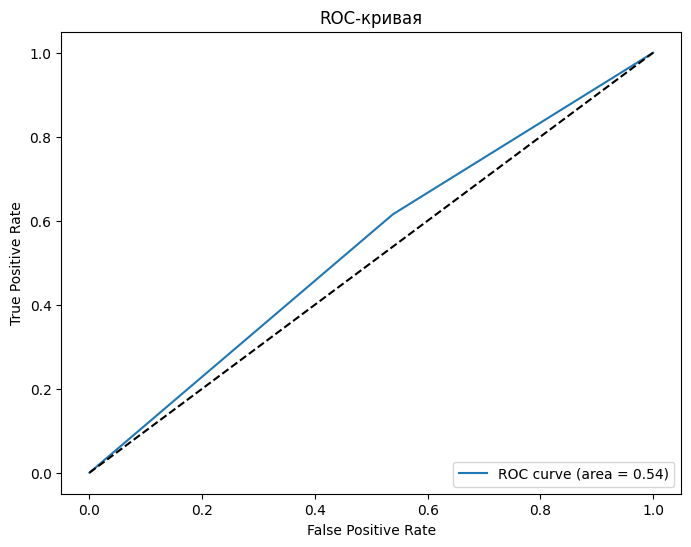

In [ ]:
from sklearn.metrics import roc_curve, auc

Y_test_prob = model.predict_proba(X_test)[:, 1]

# Расчет ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test_bal, y_pred_bal)
roc_auc = auc(fpr, tpr)

# Построение графика
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

**Общая точность** модели составила 0.54, значит, модель 54% наблюдений классифицировала верно. 6 раз модель правильно предсказала, что пациент еще жив, 8 раз - что умер. Ошибочно умертвила 7 пациентов и пропустила 5 умерших. Прецизионность или **точность классификации** составила 0.53, значит, модель 53% пациентов, которые умерли, классифицировала как умерших. **Полнота классификации** равна 0.62, то есть модель нашла и отнесла к классу 62% от всех умерших. **Гармоническое среднее** между полнотой и точностью классификации - 0.57, это говорит о том, что метрики, в целом, сбалансированы. **ROC-AUC** равно 0.54, модель классифицирует лучше случайного угадывания, но имеет возможности для улучшения. Так же стоит отметить, что выборка очень маленькая, для улучшения модели нужно больше наблюдений.

In [ ]:
y = df['DEATH']

X = df.drop(['DEATH'], axis=1)

In [ ]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True)

In [ ]:
X

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [ ]:
print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.70      0.67        37
           1       0.42      0.35      0.38        23

    accuracy                           0.57        60
   macro avg       0.53      0.53      0.52        60
weighted avg       0.55      0.57      0.56        60



In [ ]:
accuracy_score(y_test_multi, y_pred_multi)

0.5666666666666667

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi)

0.5252643948296123

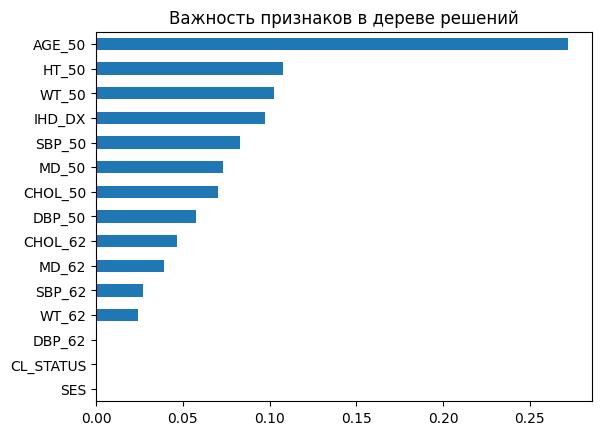

In [ ]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

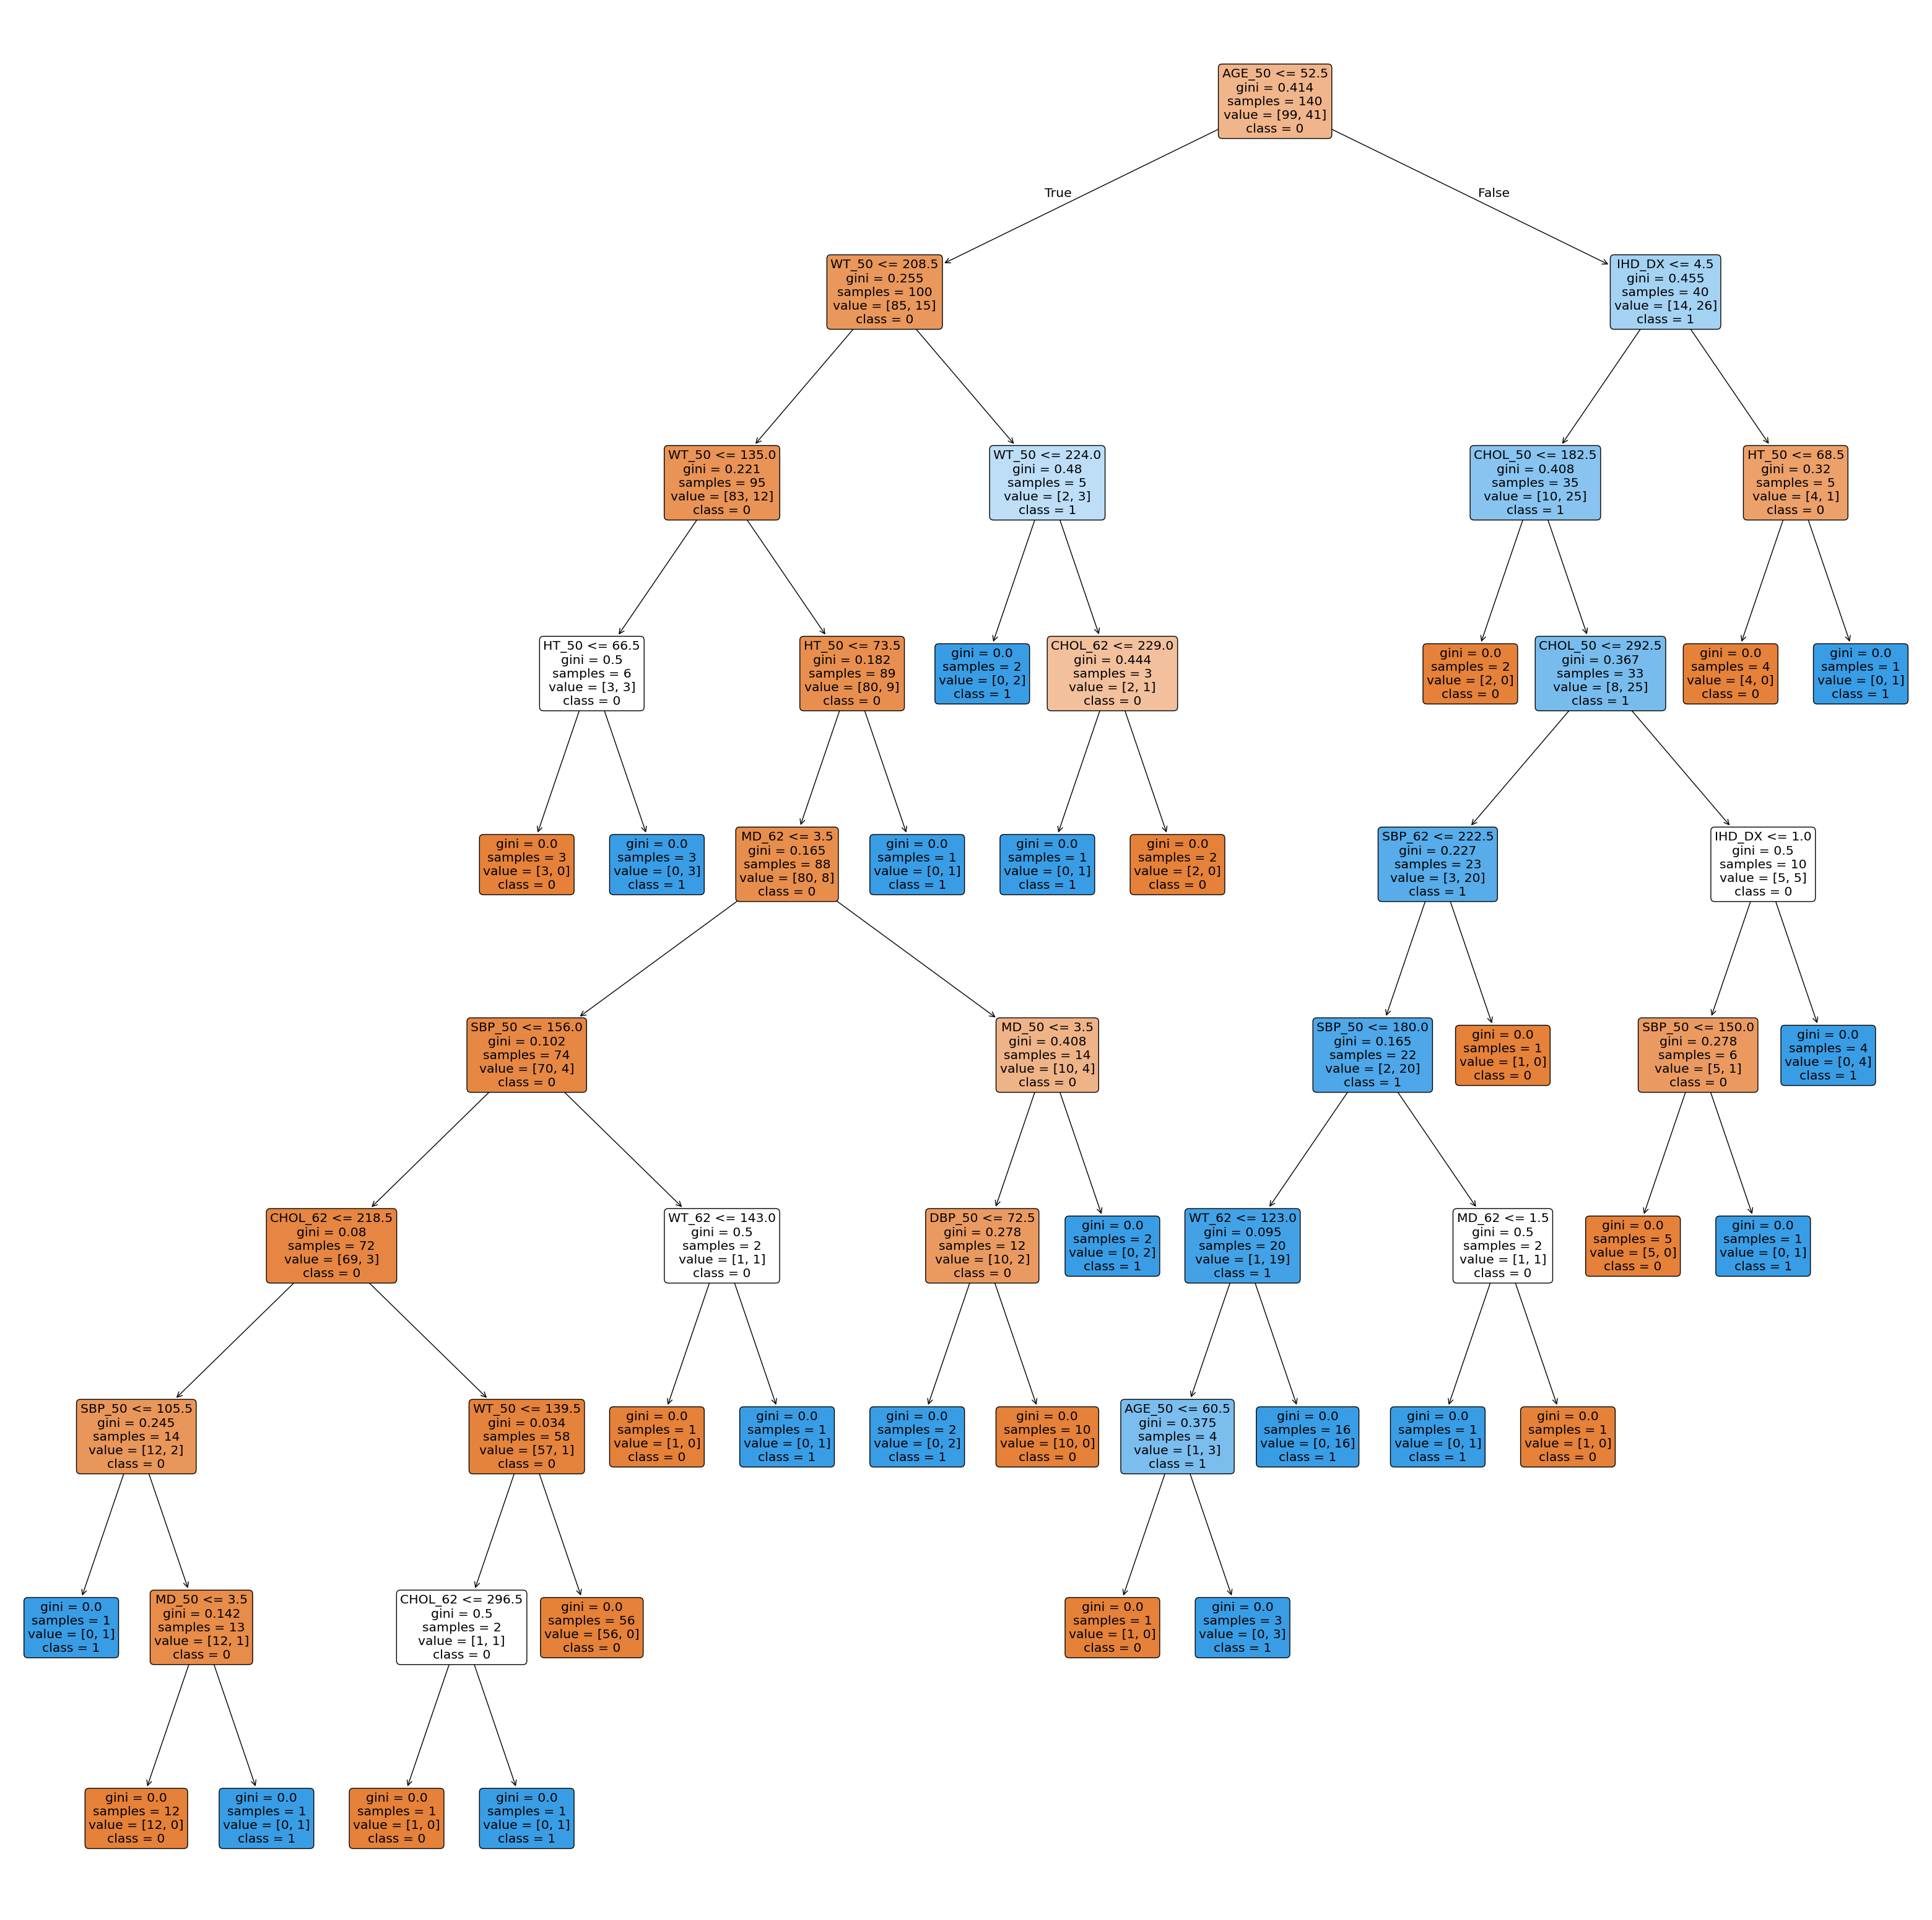

In [ ]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(40, 40))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

#Для oversampling
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

#Для undersampling
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled)

# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

#Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80        37
           1       0.89      0.73      0.80        44

    accuracy                           0.80        81
   macro avg       0.81      0.81      0.80        81
weighted avg       0.82      0.80      0.80        81



Использовал **SMOTE для oversampling** и **TomeLinks для undersampling**. Благодаря такой комбинации методов мы синтетически получим новые точки для меньшего класса и улучшим границу разделения между классами за счет удаления пар-соседий из классов.

In [ ]:
accuracy_score(y_test_multi, y_pred_multi)

0.8024691358024691

In [ ]:
balanced_accuracy_score(y_test_multi, y_pred_multi)

0.8095823095823096

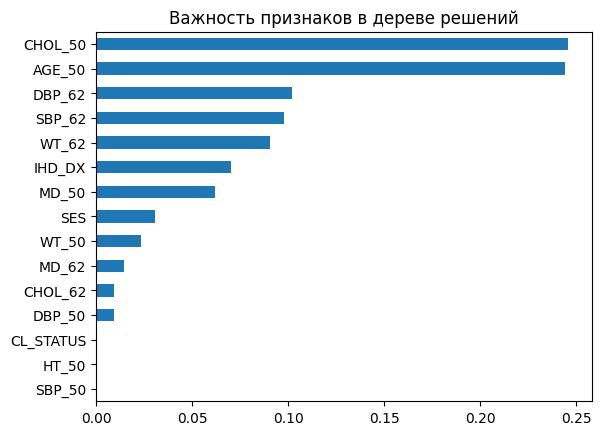

In [ ]:
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

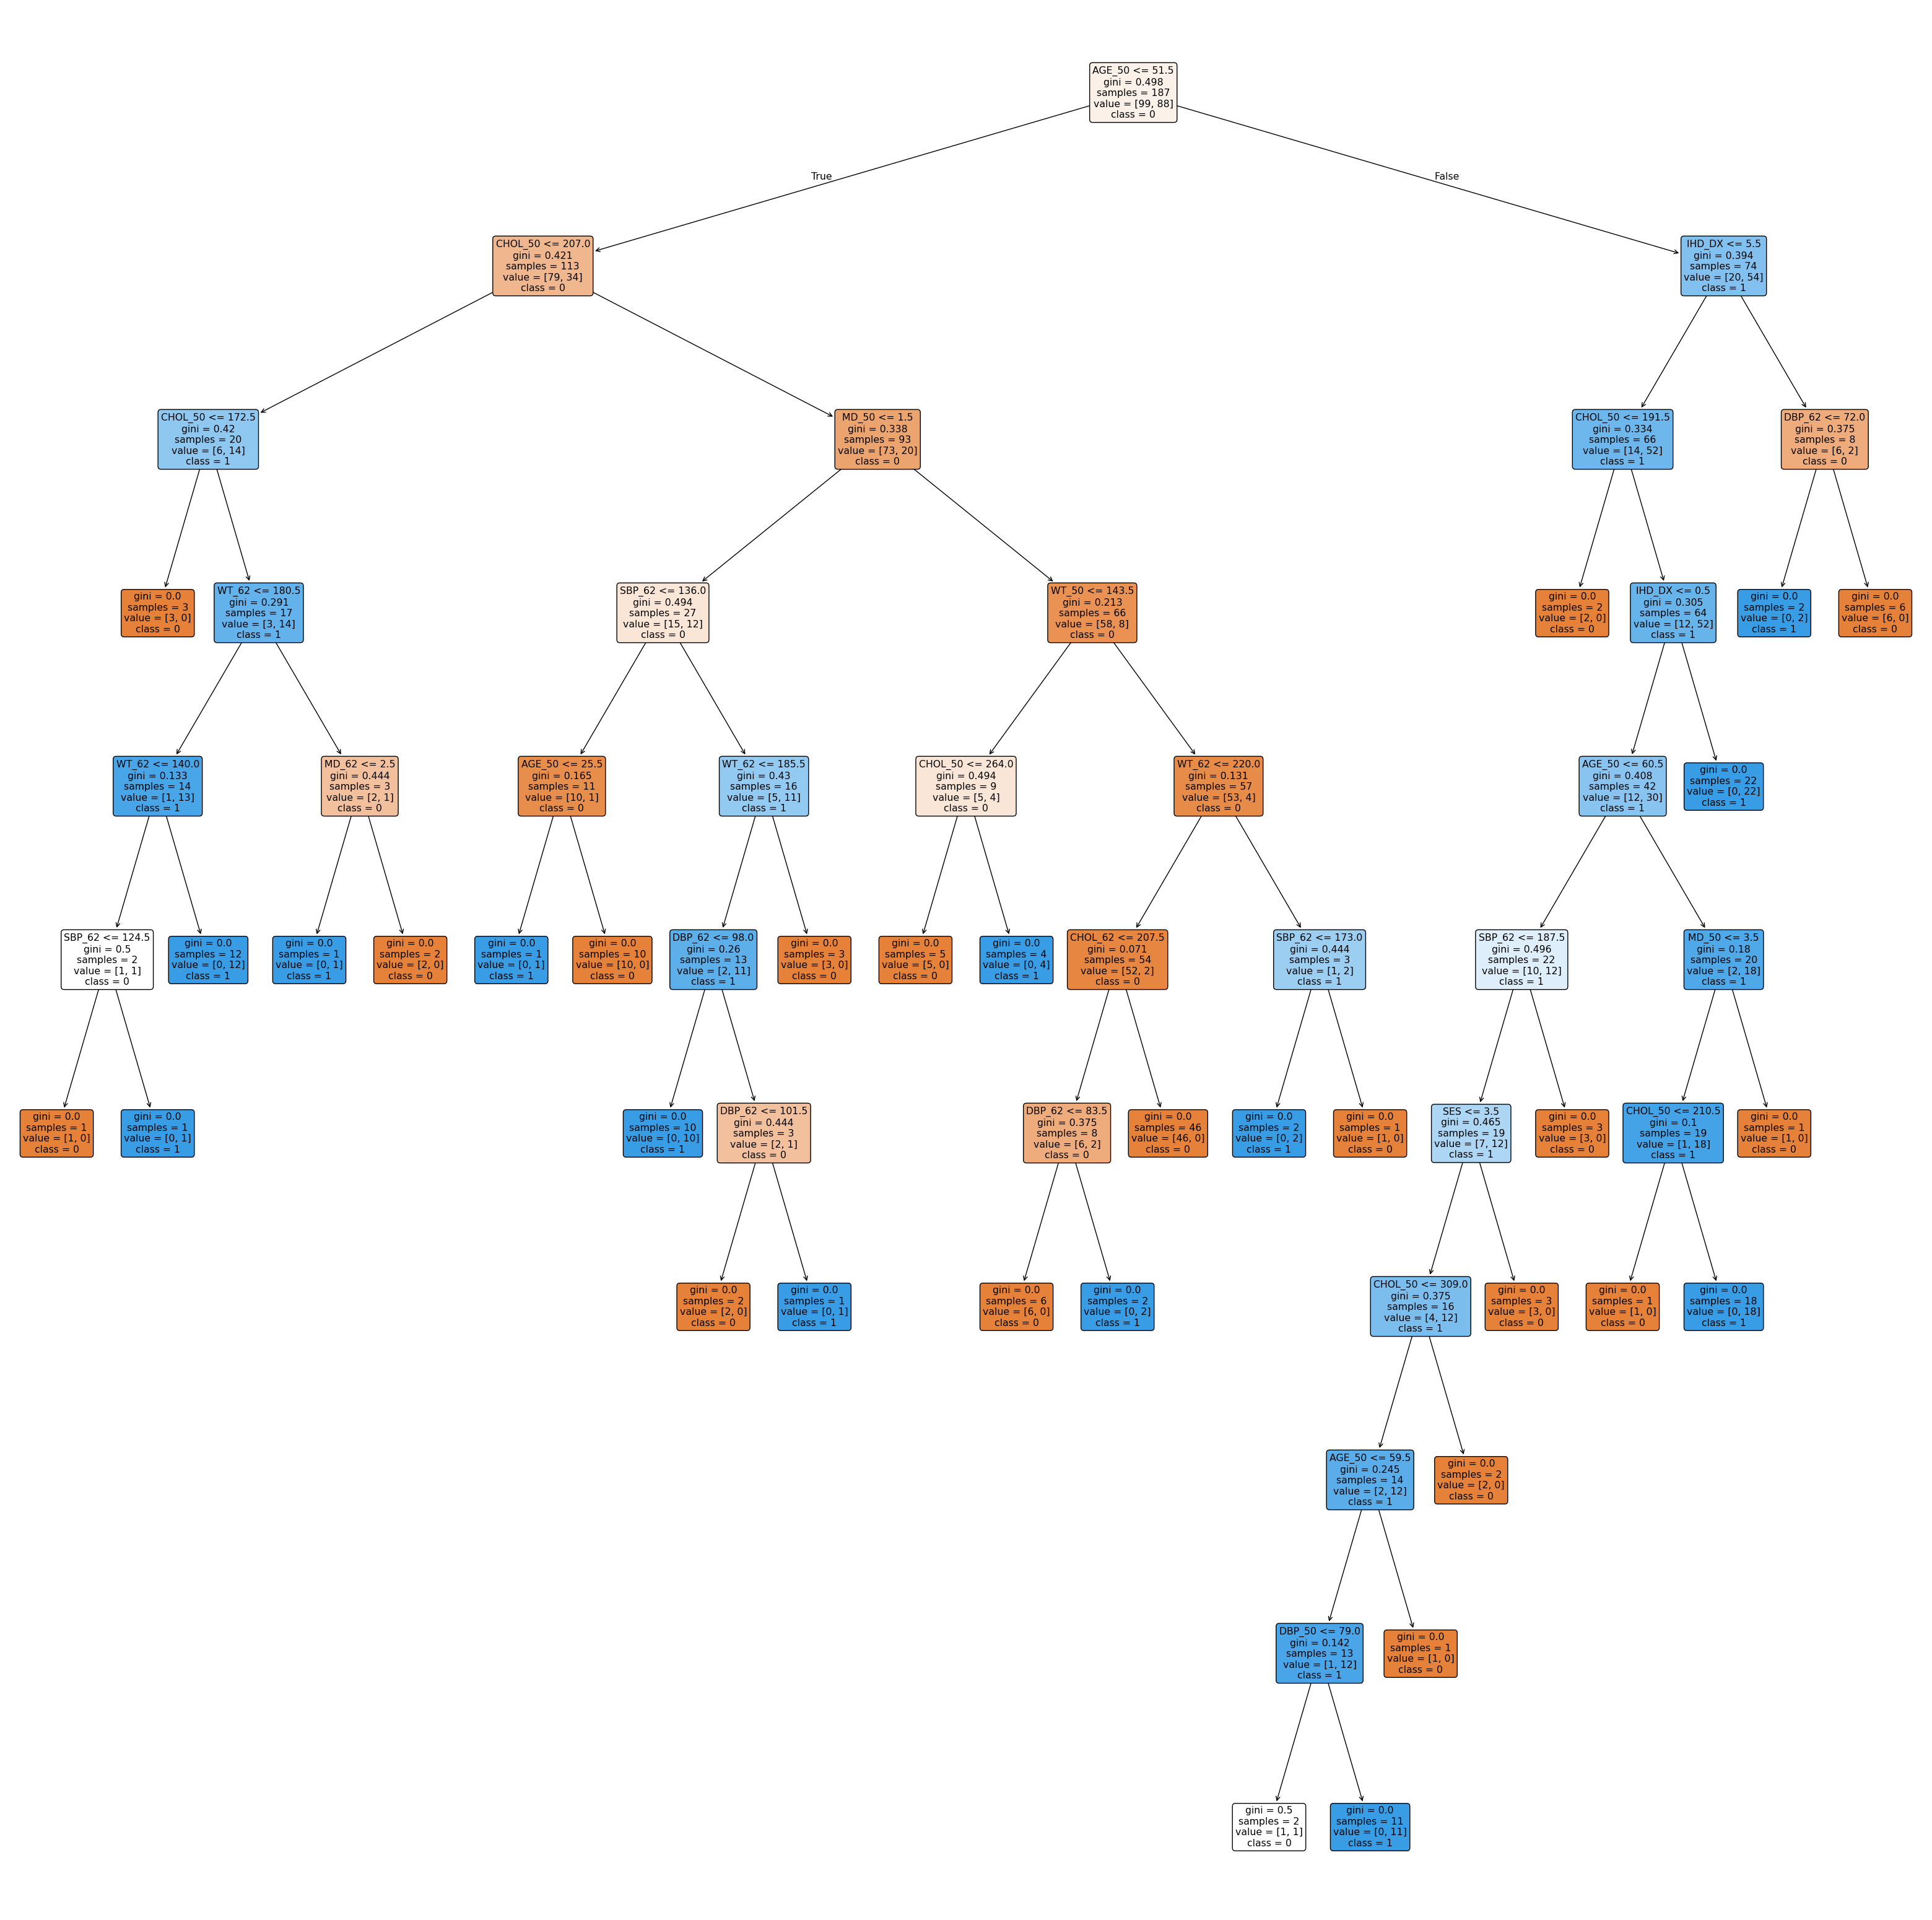

In [ ]:
# Визуализируем дерево решений
plt.figure(figsize=(40, 40))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()